# Анализ пользователей приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания-разработчик развлекательного приложения Procrastinate Pro+ терпит убытки.

**Задачи проекта**:
* изучить, откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

**Цель проекта** - разобраться в причинах убытков и помочь компании выйти в плюс.

## План работы

* Предобработка данных
* Дополнительные расчеты (LTV, ROI, Retention Rate, CR)
* Исследовательский анализ данных
* Маркетинговые исследования
* Оценка окупаемости рекламы
* Общий вывод

## Загрузка данные и подготовка их к анализу

In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загружаем данные из таблицы visits_info_short

visits = pd.read_csv('visits_info_short.csv')

In [3]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
# загружаем данные из таблицы orders_info_short

orders = pd.read_csv('orders_info_short.csv')

In [5]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [6]:
# загружаем данные из таблицы costs_info_short

costs = pd.read_csv('costs_info_short.csv')

In [7]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

### Предобработка данных

In [8]:
# меняем регистр во всех столбцах на нижний
visits = visits.rename(columns=str.lower)
orders = orders.rename(columns=str.lower)
costs = costs.rename(columns=str.lower)

In [9]:
# меняем названия столбцов в соответствии со "змеиным регистром"
visits = visits.rename(columns = {'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})
orders = orders.rename(columns = {'user id': 'user_id', 'event dt': 'event_dt'})

In [10]:
# преобразуем данные о времени

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [11]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

0

0

0

Ни в одной из трех таблиц нет пропущенных значений и дубликатов. Для удобства анализа и соблюдения правил наименований столбцов все названия столбцов во всех таблицах были приведены к "змеиному" регистру. Значения столбцов с датами были преобразованы в формат datetime.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [13]:
# задаем функцию для определения профиля пользователя

def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

       # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = round(ad_costs['costs'] / ad_costs['unique_users'],2)

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [14]:
# задаем функцию для расчета LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
# задаем функцию для расчета удержания

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time


In [16]:
# задаем функцию для расчета конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [17]:
# задаем функцию для сглаживания графиков

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [18]:
# задаем функцию для построения графиков для кривых и динамики LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# задаем функцию для построения графиков для кривых и динамики удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [20]:
# задаем функцию для построения графиков для кривых и динамики конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [21]:
# получаем профили пользователей

users = get_profiles(visits, orders, costs)

users.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True              1.09  
1  2019-07-09 2019-07-01  False              1.11  
2  2019-10-01 2019-10-01  False              0.00  
3  2019-08-22 2019-08-01  False              0.99  
4  2019-10-02 2019-10-01  False              0.23

In [22]:
# определяем минимальную дату привлечения пользователей

min_date = costs.agg({'dt': 'min'})
min_date

dt    2019-05-01
dtype: object

In [23]:
# определяем максимальную дату привлечения пользователей

max_date = costs.agg({'dt': 'max'})
max_date

dt    2019-10-27
dtype: object

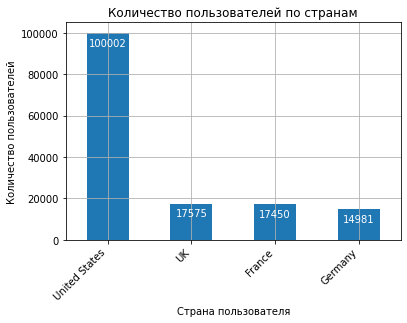

In [24]:
# определяем, из каких стран приходят посетители

plot_r = (
    users.pivot_table(index = 'region', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(6,4), grid=True, rot = 45, title='Количество пользователей по странам', legend=False)
)

for bar in plot_r.patches:
     plot_r.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, -10), color='w',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Страна пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Больше всего пользователей приходят из США, в 5.7 раз больше, чем из Великобритании и в 6.7 раз больше, чем из Германии.

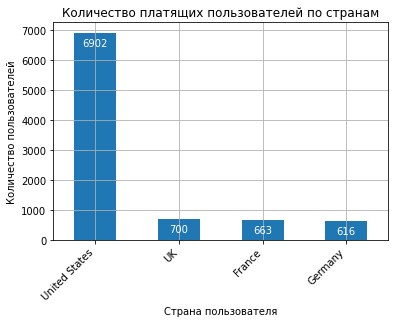

In [25]:
# определяем, какие страны дают больше всего платящих пользователей

plot_rp = (
    users.query('payer == True')
    .pivot_table(index = 'region', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(6,4), grid=True, rot = 45, title='Количество платящих пользователей по странам', legend=False)
)

for bar in plot_rp.patches:
     plot_rp.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, -10), color='w',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Страна пользователя')
plt.ylabel('Количество пользователей')
plt.show()

In [26]:
# определяем долю платящих пользователей по странам

(
     users.groupby('region')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format(({'payer': '{:.2%}'}))
)

Платящих пользователей тоже больше всего в США, они составляют 7% от общего числа пользователей в этой стране. Но при этом количество таких пользователей уже в 10-11 раз выше, чем в других странах, где процент платящих пользователей находится в пределах 3.8-4.1%. То есть в США люди гораздо охотнее пользуются платными опциями.

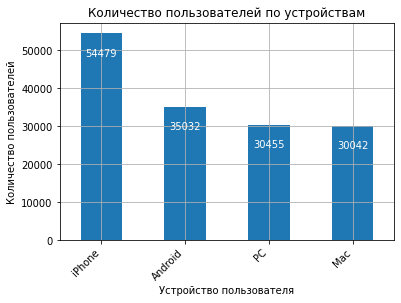

In [27]:
# определяем, какими устройствами пользуются клиенты 

plot_d = (
    users.pivot_table(index = 'device', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(6,4), grid=True, rot = 45, title='Количество пользователей по устройствам', legend=False)
)

for bar in plot_d.patches:
     plot_d.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, -20), color='w',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Устройство пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Наиболее популярным типом устройства у пользователей является iPhone. Количество пользователей этого устройства в 1.5 раза превышает количество пользователей с ОС Android.

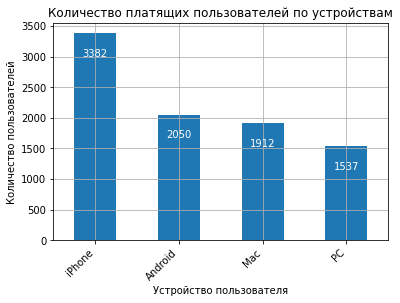

In [28]:
# определяем, какие устройства предпочитают платящие пользователи

plot_dp = (
    users.query('payer == True')
    .pivot_table(index = 'device', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(6,4), grid=True, rot = 45, title='Количество платящих пользователей по устройствам', legend=False)
)

for bar in plot_dp.patches:
     plot_dp.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, -20), color='w',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Устройство пользователя')
plt.ylabel('Количество пользователей')
plt.show()

In [29]:
# определяем долю платящих для каждого устройства

(
     users.groupby('device')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format(({'payer': '{:.2%}'}))
)

Похожая ситуация и с платящими пользователями: у большинства iPhone, и количество платящих пользователей этого устройства в 1.6 раза превышает количество платящих пользователей с ОС Android.  
Но при этом %% платящих пользователей больше всего у тех, кто пользуется компьютером Mac - 6.36%. А меньше всего у тех, кто заходит с обычного компьютера - 5.05%, при этом общее количество пользователей Mac И PC почти одинаково.

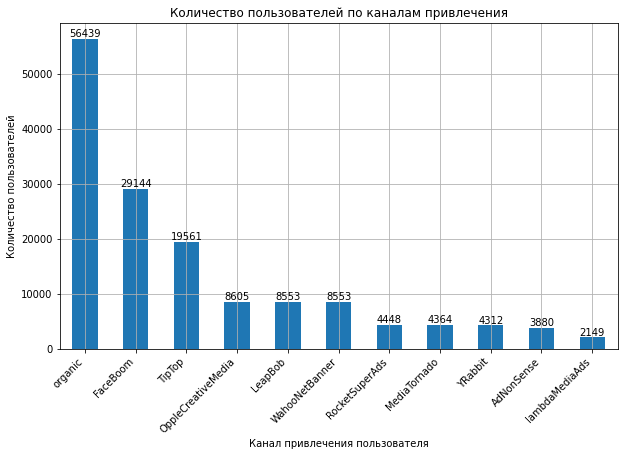

In [30]:
# изучаем рекламные источники привлечения и определите каналы, из которых пришло больше всего пользователей

plot_c = (
    users.pivot_table(index = 'channel', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(10,6), grid=True, rot = 45, title='Количество пользователей по каналам привлечения', legend=False)
)

for bar in plot_c.patches:
     plot_c.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, 5), color='black',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Канал привлечения пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Больше всего пользователей приходит из органического поиска - почти в 2 раза больше, чем из второго по популярности канала FaceBoom.

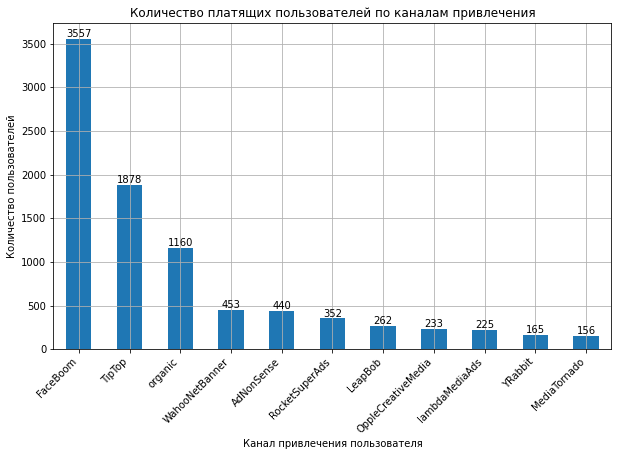

In [31]:
# определите каналы, из которых пришло больше всего платящих пользователей

plot_cp = (
    users.query('payer == True')
    .pivot_table(index = 'channel', values = 'user_id', aggfunc = 'count')
    .sort_values(by='user_id', ascending=False)
    .plot(kind='bar', figsize=(10,6), grid=True, rot = 45, title='Количество платящих пользователей по каналам привлечения', legend=False)
)

for bar in plot_cp.patches:
     plot_cp.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, 5), color='black',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Канал привлечения пользователя')
plt.ylabel('Количество пользователей')
plt.show()

In [32]:
# определяем долю платящих для каждого канала привлечения

(
     users.groupby('channel')
    .agg({'user_id': 'nunique', 'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format(({'payer': '{:.2%}'}))
)

И по количеству и по проценту платящих пользователей лидирует канал FaceBoom (12.2% платящих). А среди пользователей, пришедших из Organic, самый маленький процент платящих пользователей - 2.06%.

### Вывод:

В условиях проекта заложено, что предоставлены данные о пользователях, привлеченных с 1 мая по 27 октября 2019 года, а мы анализируем данные 1 ноября 2019 года.   
Минимальная дата привлечения пользователей - 1 мая 2019 г., максимальная дата - 27 октября 2019г. Максимальная дата с учетом горизонта анализа - 19 октября 2019 г.

Пользователи приходят в приложение из 4 стран: США, Великобритания, Франция и Германия. США лидируют по всем показателям: 
* общее количество пользователей около 100 тыс., что в 6-7 раз больше, чем у других стран,
* количество платящих пользователей около 6.9 тыс., что в 10-11 раз больше, чем у других стран,
* процент платящих пользователей 6.9%.

Пользователи заходят в приложение с 4 типов устройств iPhone, Android, Mac и PC. Наиболее популярным устройством является iPhone:
* общее количество пользователей около 54.5 тыс., что в 1.5 раз больше, чем у Android,
* количество платящих пользователей около 3.4 тыс., что в 1.6 раз больше, чем у Android,
* процент платящих пользователей 6.21%, но тут уступается первенство Mac, у которого процент платящих пользователей выше и составляет 6.36%.

Количество рекламных источников привлечения пользователей - 10. Наибольший траффик составляют пользователи из органического канала - 54.4 тыс. Далее следуют пользователи из FaceBoom и TipTop (29.1 и 19.4 тыс. соответсввенно), они же являются и лидерами по количеству платящих пользователей (3.6 и 1.9 тыс. соответсввенно), тогда как Organic только на третьем месте по количеству платящих пользователей (1.2 тыс.).  
Если посмотреть на таблицу с процентами платящих пользователей по каналам, то лидерах будут FaceBoom (12.2%), AdNonSense (11.34%), lambdaMediaAds (10.47%), TipTop только на 4м месте (9.6%), а на последнем месте Organic (2.06). Видно, что у каналов AdNonSense и lambdaMediaAds одни из наиболее высоких процентов платящих пользователей, но при этом у них самые низкие показатели общего количества клиентов.

## Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [33]:
# считаем общую сумму расходов на маркетинг

round(costs['costs'].sum(), 1)

105497.3

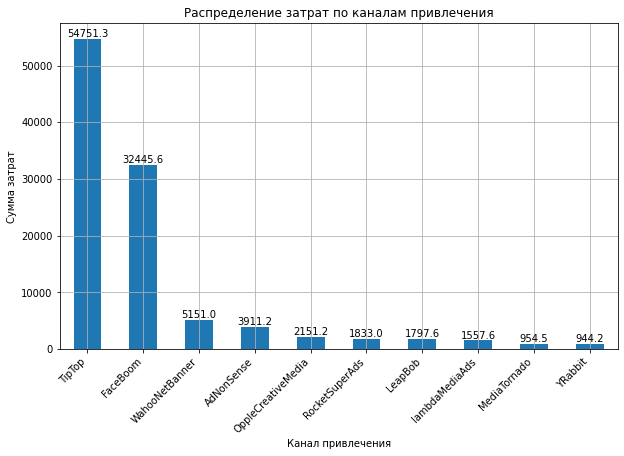

In [34]:
# определяем, как траты распределены по источникам

plot_costs = (
    costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum')
    .sort_values(by='costs', ascending=False)
    .plot(kind='bar', figsize=(10,6), grid=True, rot = 45, title='Распределение затрат по каналам привлечения', legend=False)
)

for bar in plot_costs.patches:
     plot_costs.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, 5), color='black',
                    textcoords='offset points')

plt.xticks(horizontalalignment='right')
plt.xlabel('Канал привлечения')
plt.ylabel('Сумма затрат')
plt.show()

In [35]:
# определяем процент затрат каждого канала от общей суммы

(
costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum')
    .sort_values(by='costs', ascending=False)
    .div(costs['costs'].sum())
    .style.format({'costs': '{:.2%}'})
)

Общая сумма расходов на рекламу составила 105.5 тыс условных денежных единиц (у.е.).

Из графика видно, что наибольшая сумма затрат на рекламу пришлась на канал TipTop (51.9% от общих затрат). На втором месте канал FaceBoom (30.75% от общих затрат), на который, как определили ранее, приходится наибольший процент платящих пользователей. Эти два канала являются основными каналами привлечения пользователей, т.к. на них приходится большая часть затрат, а также на эти каналы приходится 61% от общего количества платящих пользователей.

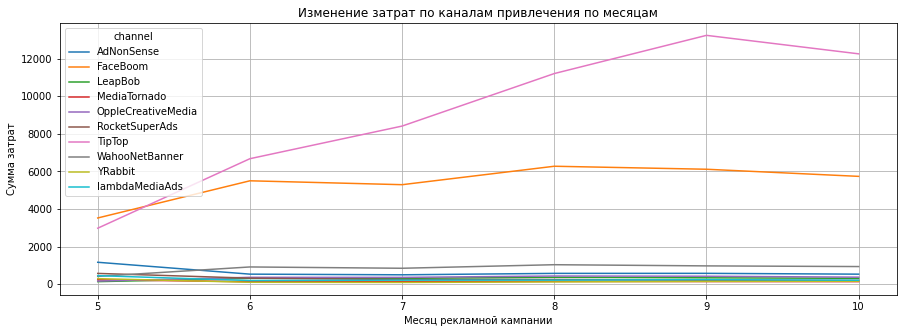

In [36]:
# Визуализируйте изменения метрик во времени

costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month # Добавляем колонку с месяцем привлечения пользователей

(
    costs.pivot_table(index='dt_month', columns='channel', values='costs', aggfunc='sum')
    .plot(figsize=(15, 5), grid=True, title='Изменение затрат по каналам привлечения по месяцам')
)
plt.xlabel('Месяц рекламной кампании')
plt.ylabel('Сумма затрат')
plt.show()

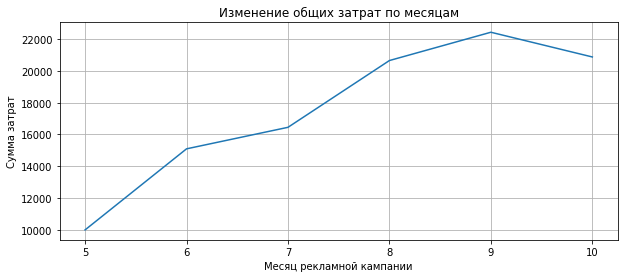

In [37]:
(
    costs.pivot_table(index='dt_month', values='costs', aggfunc='sum')
    .plot(figsize=(10, 4), grid=True, title='Изменение общих затрат по месяцам', legend=False)
)
plt.xlabel('Месяц рекламной кампании')
plt.ylabel('Сумма затрат')
plt.show()

Из графиков видно, что наибольшие затраты на рекламные кампании пришлись на сентябрь, до этого времени затраты росли, начиная с мая, а в октябре упали, но у нас есть данные не за полный октябрь (не хватает данных за последние 4 дня), поэтому, возможно, затраты за полный октябрь находятся на том же уровне, что и в сентябре.

Наибольшие затраты приходятся на каналы TipTop и FaceBoom, при чем если в мае затраты на них примерно одинаковы, то затем затраты на TipTop начинают резко расти, а затраты на FaceBoom несколько выросли в июне, а затем оставались примерно на том же уровне. Затраты на остальные каналы на протяжении всего времени оставались одинаковыми.

In [38]:
# определяем, сколько в среднем стоило привлечение одного пользователя из каждого источника

round(
    users.groupby('channel').agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
    , 2
)

acquisition_cost
channel                             
TipTop                          2.80
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
MediaTornado                    0.22
YRabbit                         0.22
LeapBob                         0.21
organic                         0.00

In [39]:
# определяем средний CAC на одного пользователя для всего проекта

# удаляем из расчета профили из органического канала, т.к. из стоимость привлечения равна 0
round(users.query('channel != "organic"')['acquisition_cost'].mean(), 2)

1.13

Средняя стоимость привлечения одного пользователя составила 1.13 у.е. При этом наибольшая стоимость на пользователя у каналов TipTop (2.8.у.е.) и FaceBoom (1.11 у.е.).

### Вывод:

Общая сумма расходов на рекламу составила 105.5 тыс условных денежных единиц (у.е.).

Наибольшая сумма затрат на рекламу пришлась на канал TipTop. На втором месте канал FaceBoom. Эти два канала являются основными каналами привлечения пользователей, т.к. на них приходится большая часть затрат, а также у них наибольшая средняя стоимость привлечения на пользователя (2.8 и 1.11 у.е. соответсnвенно). Средняя стоимость привлечения одного пользователя в целом составила 1.13 у.е.

Наибольшие общие затраты на рекламные кампании пришлись на сентябрь, до этого времени затраты росли, начиная с мая, но рост затрат происходил за счет роста затрат в канале TipTop. Затрат FaceBoom выросли в июне, после уже не поднимались, а затраты на остальные каналы на протяжении всего времени оставались одинаковыми.

## Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Анализ общей окупаемость рекламы

In [40]:
# для анализа принимаем момент анализа 1 ноября 2019г., горизонт анализа - 14 дней.
# не включаем в анализ органических пользователей, т.к. не было затрат для их привлечения.

observation_date = datetime(2019, 11, 1).date() # дата анализа данных
horizon = 14 # количество дней, в течение которых пользователи должны окупаться после привлечения

users_non_organic = users.query('channel != "organic"')

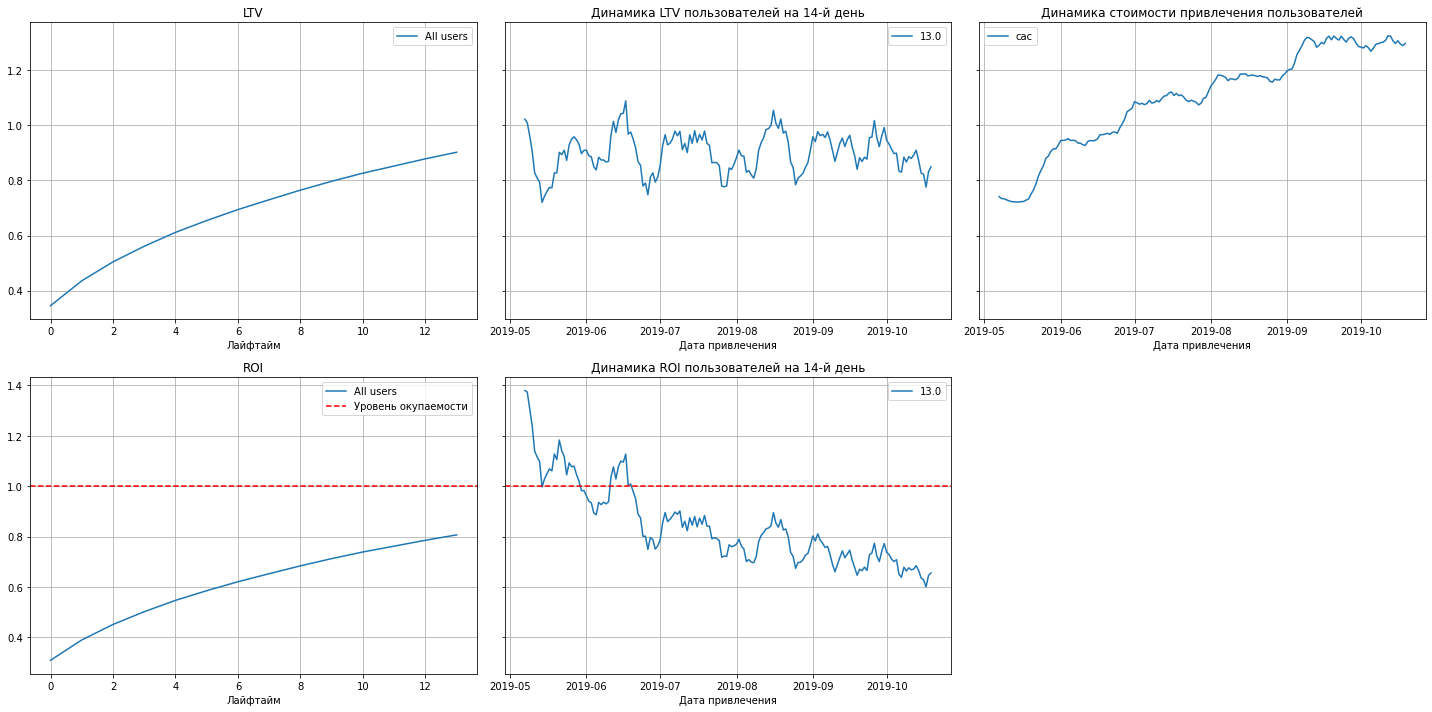

In [41]:
# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_organic, orders, observation_date, horizon
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

Из графиков видно, что ROI находится ниже уровня окупаемости. Динамика ROI пользователей на 14-й день со временем падает, а динамика стоимости привлечения пользователей растет. LTV стабильно растет.

### Анализ окупаемости рекламы с разбивкой по устройствам

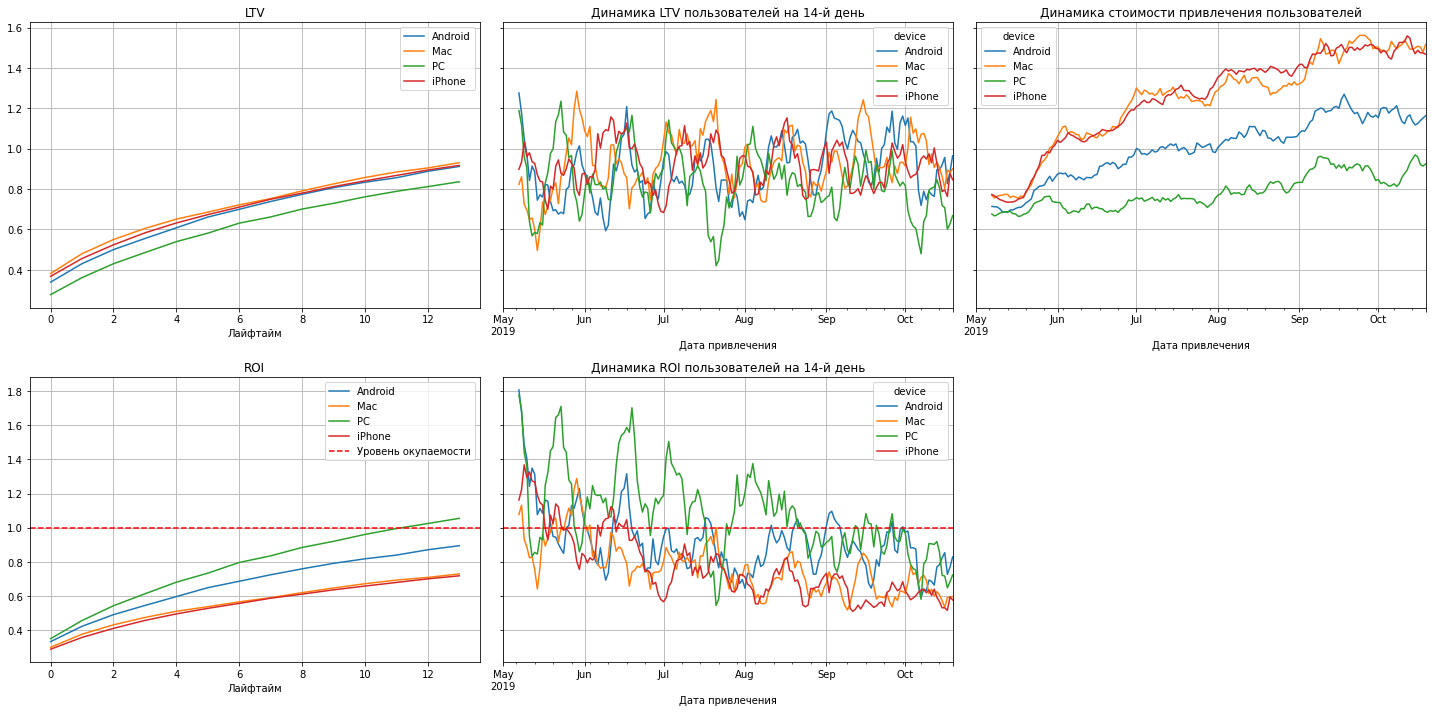

In [42]:
# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_organic, orders, observation_date, horizon, dimensions=['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

В целом, не окупаются все пользователи, только те, кто заходит с PC, пересекают уровень окупаемости на 11 день. При этом по графику динамики стоимости привлечения клиентов видно, что наименьшие расходы были как раз на пользователей PC, а наибольшие - на пользователей iPhone и Mac. Динамика ROI снижается у всех устройств при росте стоимости привлечения пользователей.

### Анализ окупаемости рекламы с разбивкой по странам

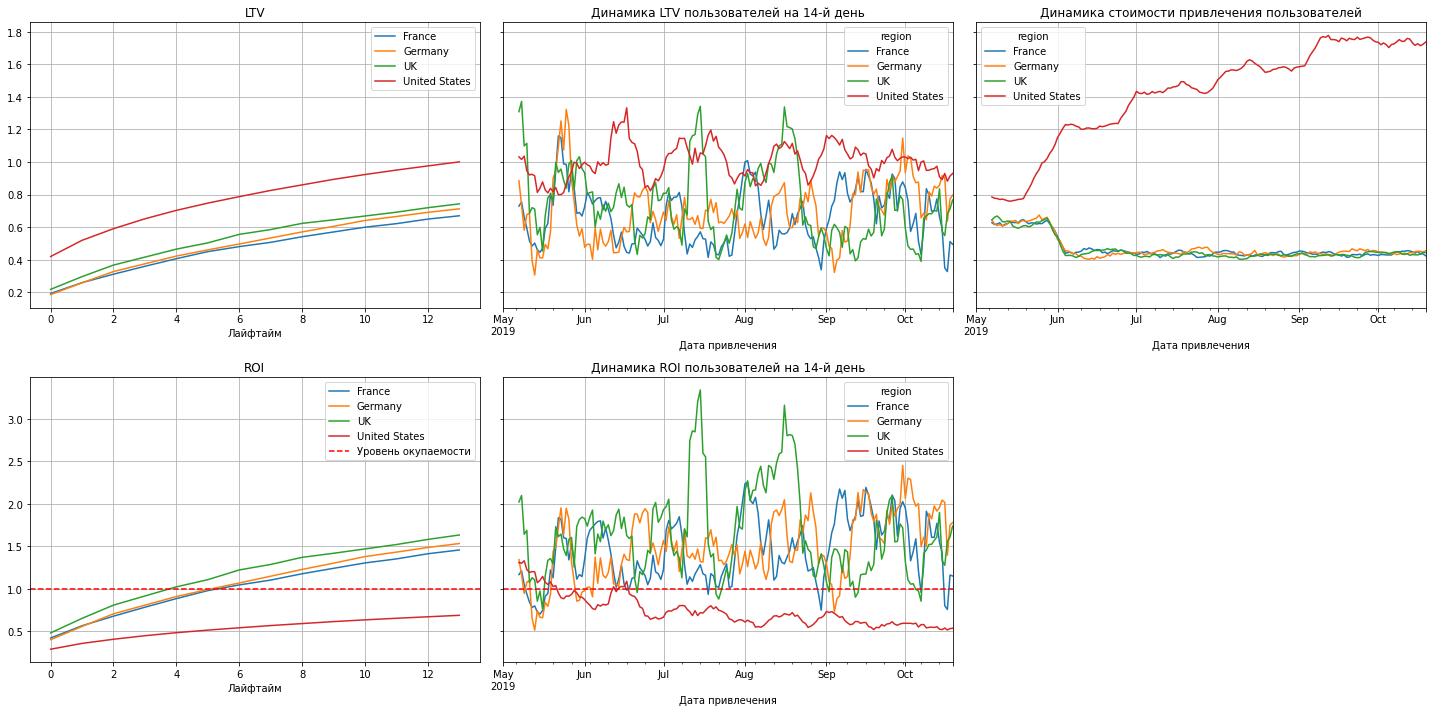

In [43]:
# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_organic, orders, observation_date, horizon, dimensions=['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

Из графиков видно, что реклама не окупилась только в США, а в остальных регионах реклама окупается. Динамика стоимости привлечения пользователей растет только в США и показывает огромный разрыв расходов между США и другими странами, где роста стоимости привлечения пользователей не наблюдается. Динамика ROI показывает снижение окупаемости рекламных расходов в США и находится ниже уровня окупаемости. Динамика LTV подвержена сезонности и стабильна, LTV в США выше, чем в других странах.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

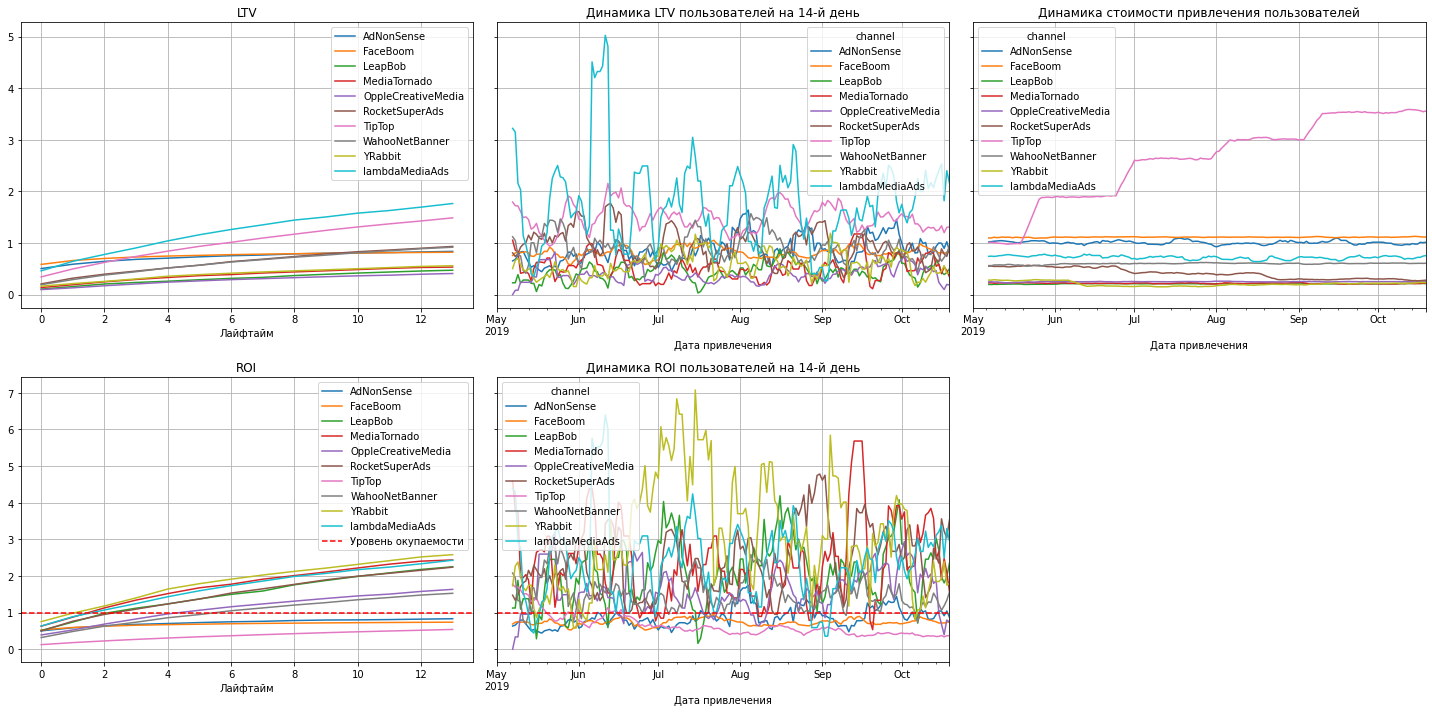

In [44]:
# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_organic, orders, observation_date, horizon, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

Динамика стоимости привлечения пользователей наиболее высокая у канала TipTop. Но при этом пользователи, пришедшие из этого канала, не окупаются. У остальных каналов динамика стоимости привлечения стабильная. Из 10 каналов окупаются все, кроме 3х: TipTop, FaceBoom, AdNonSense. Динамика ROI этих трех каналов также ниже уровня окупаемости.

### Анализ графиков конверсии и удержания

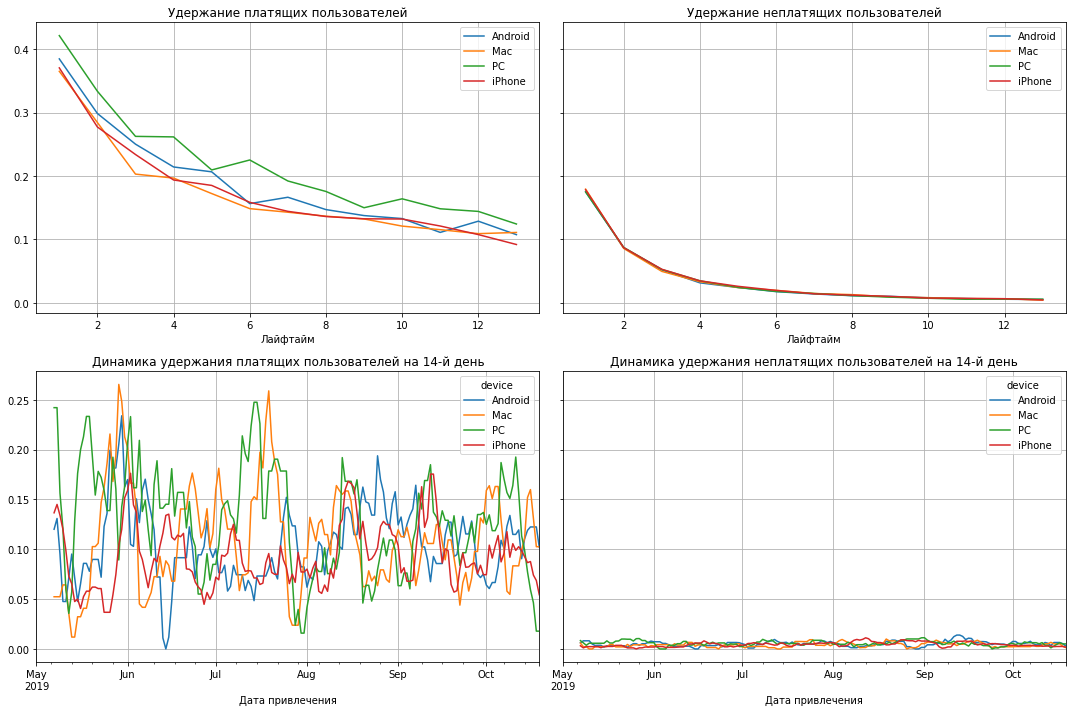

In [45]:
# анализируем графики удержания с разбивкой по устройствам

retention_raw, retention, retention_history = get_retention(
    users_non_organic, visits, observation_date, horizon, dimensions=['device']
)

plot_retention(retention, retention_history, horizon, window=7)

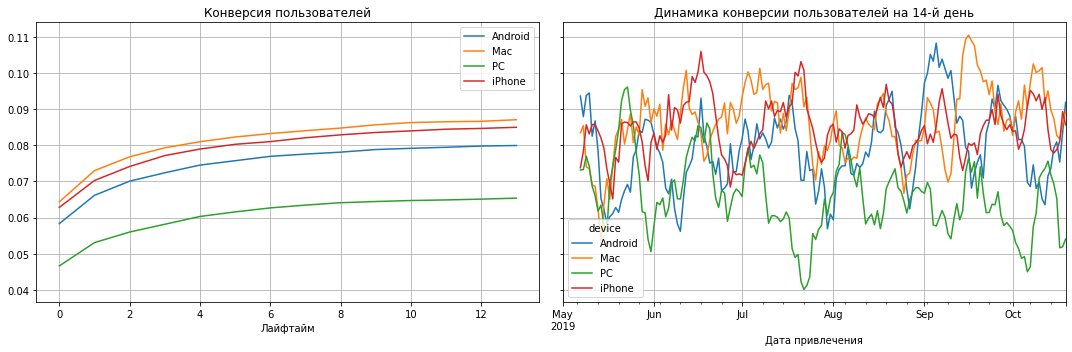

In [46]:
# анализируем графики конверсии с разбивкой по устройствам

conversion_raw, conversion, conversion_history = get_conversion(
    users_non_organic, orders, observation_date, horizon, dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon, window=7)

Наиболее высокая конверсия у пользователей Mac и iPhone, самая низкая - у пользователей PC. При этом по удержанию платящих пользователй у PC результат выше, чем у других устройств.

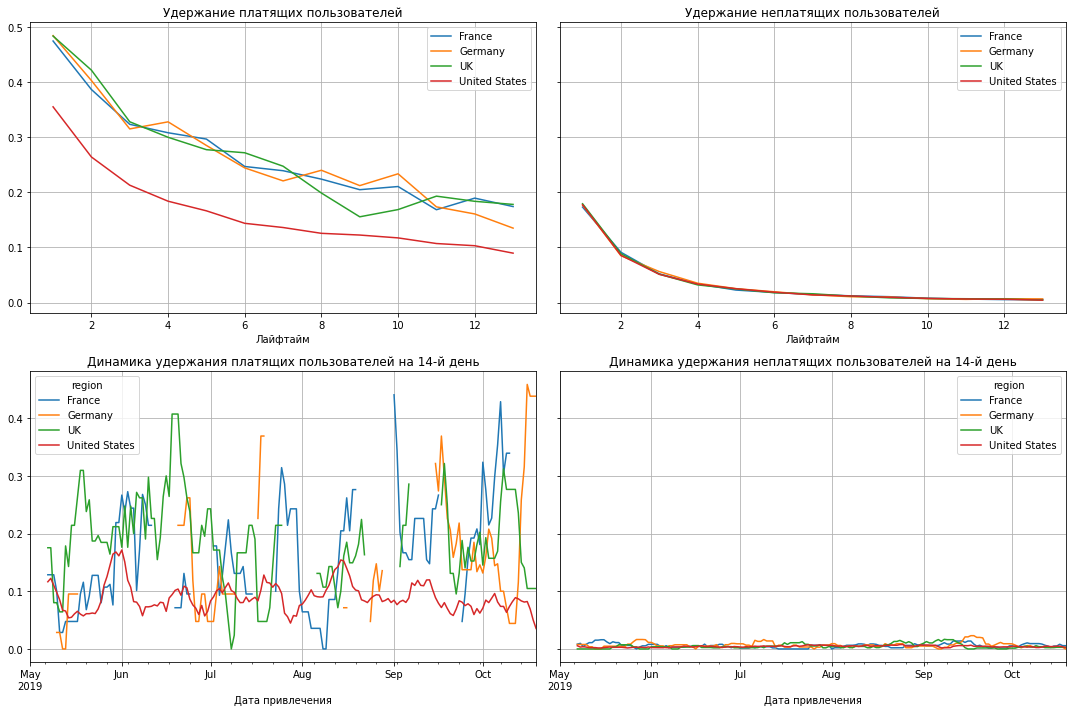

In [47]:
# анализируем графики удержания с разбивкой по странам

retention_raw, retention, retention_history = get_retention(
    users_non_organic, visits, observation_date, horizon, dimensions=['region']
)

plot_retention(retention, retention_history, horizon, window=7)

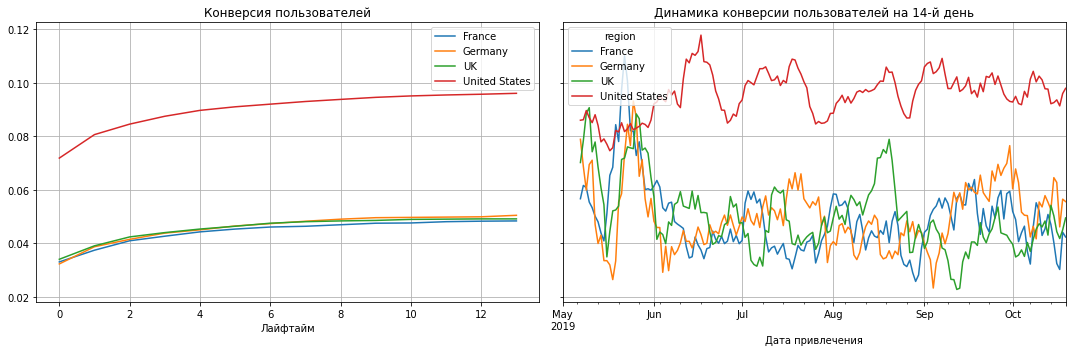

In [48]:
# анализируем графики конверсии с разбивкой по странам

conversion_raw, conversion, conversion_history = get_conversion(
    users_non_organic, orders, observation_date, horizon, dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon, window=7)

США показывают наилучшую конверсию, но при этом удержание платящих пользователей ниже, чем в других странах.

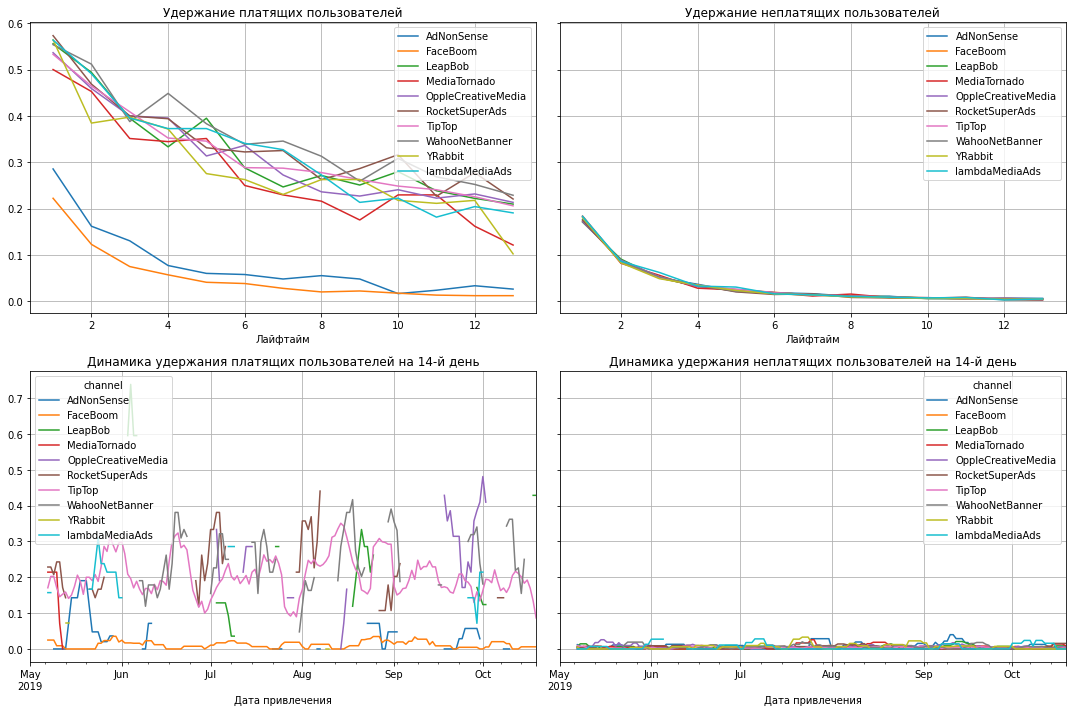

In [49]:
# анализируем графики удержания с разбивкой по рекламным каналам

retention_raw, retention, retention_history = get_retention(
    users_non_organic, visits, observation_date, horizon, dimensions=['channel']
)

plot_retention(retention, retention_history, horizon, window=7)

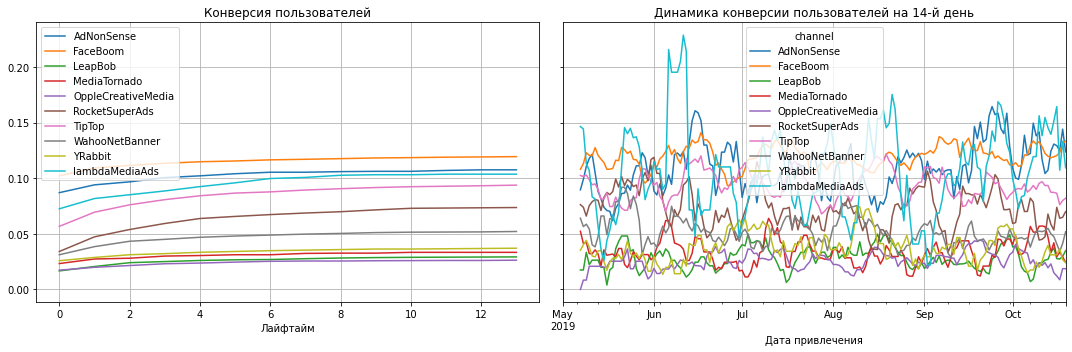

In [50]:
# анализируем графики конверсии с разбивкой по рекламным каналам

conversion_raw, conversion, conversion_history = get_conversion(
    users_non_organic, orders, observation_date, horizon, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon, window=7)

Наиболее высокая конверсия у пользователей, пришедших из FaceBoom и AdNonSense, но у этих каналов самое низкое удержание платящих пользователей.

### Анализ рекламы в США

In [51]:
# выбираем пользователей из США

users_USA = users.query('region == "United States" and channel != "organic"')

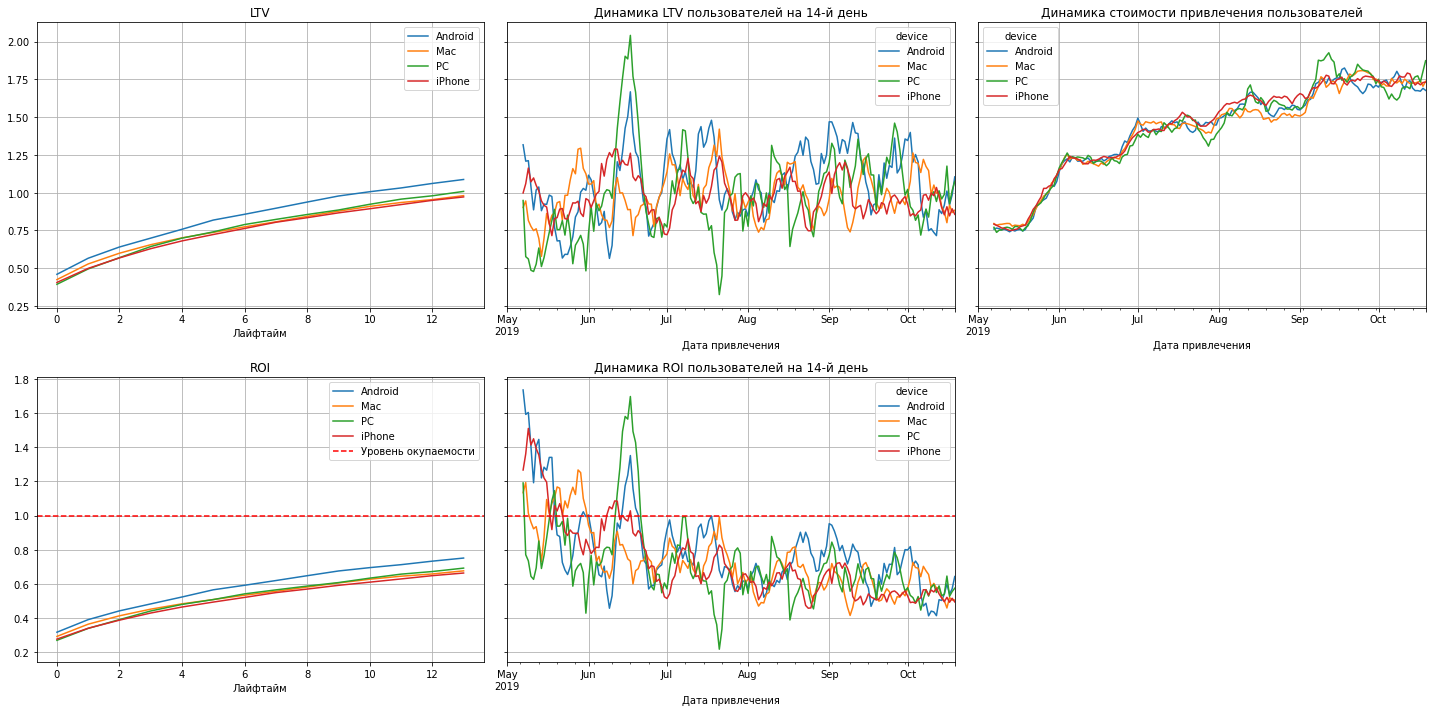

In [52]:
# анализируем окупаемость рекламы с разбивкой по устройствам

# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw_USA, ltv_USA, ltv_history_USA, roi_USA, roi_history_USA = get_ltv(
    users_USA, orders, observation_date, horizon, dimensions=['device']
)

plot_ltv_roi(ltv_USA, ltv_history_USA, roi_USA, roi_history_USA, horizon, window=7)

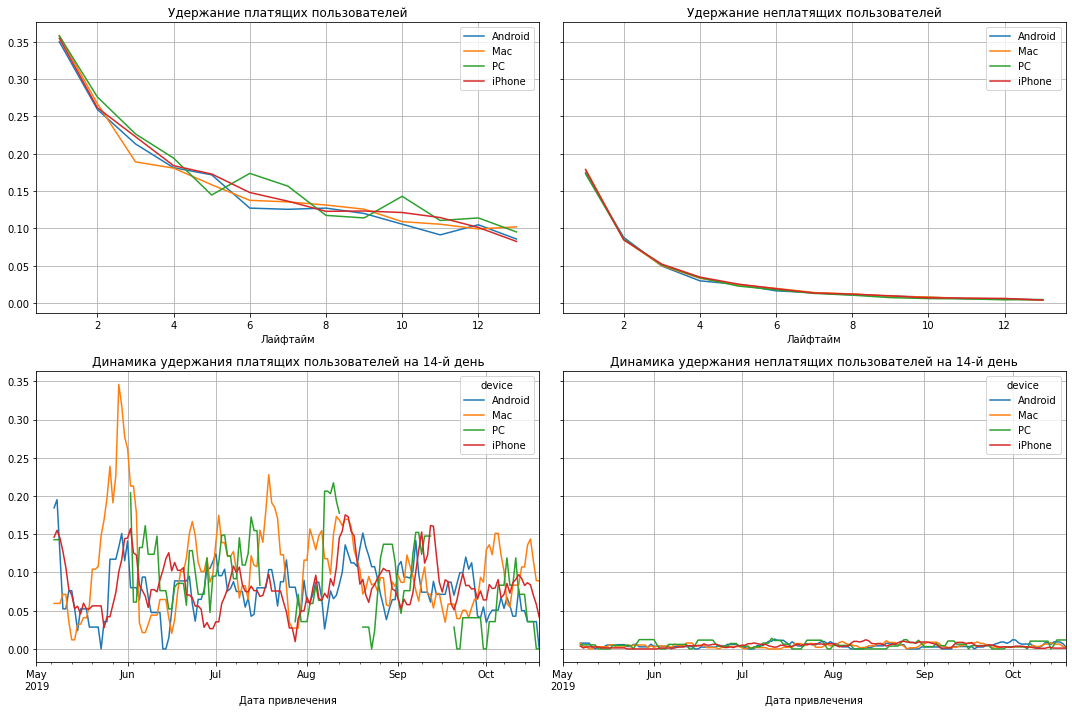

In [53]:
# анализируем графики удержания с разбивкой по устройствам

retention_raw_USA, retention_USA, retention_history_USA = get_retention(
    users_USA, visits, observation_date, horizon, dimensions=['device']
)

plot_retention(retention_USA, retention_history_USA, horizon, window=7)

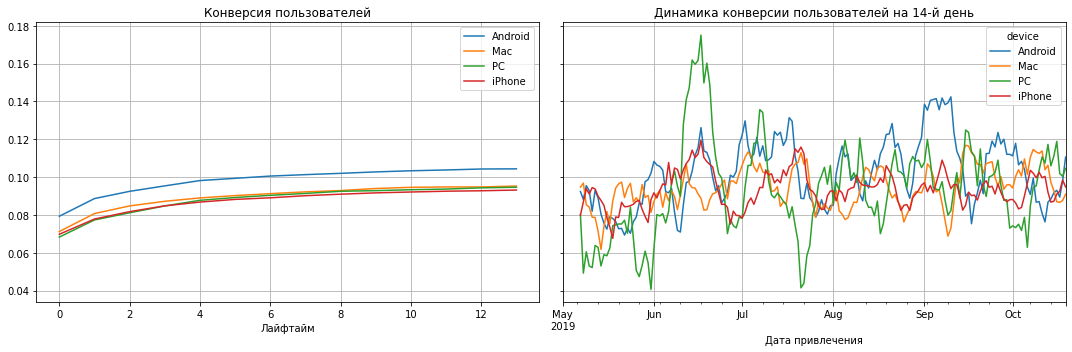

In [54]:
# анализируем графики конверсии с разбивкой по устройствам

conversion_raw_USA, conversion_USA, conversion_history_USA = get_conversion(
    users_USA, orders, observation_date, horizon, dimensions=['device']
)

plot_conversion(conversion_USA, conversion_history_USA, horizon, window=7)

Реклама в США не окупается ни на одном устройстве, при том, что стоимость привлечения пользователей растет для всех устройств. Наиболее высокая конверсия наблюдается у пользователей Android, а лучшее удержание платящих пользователей на устройстве PC.

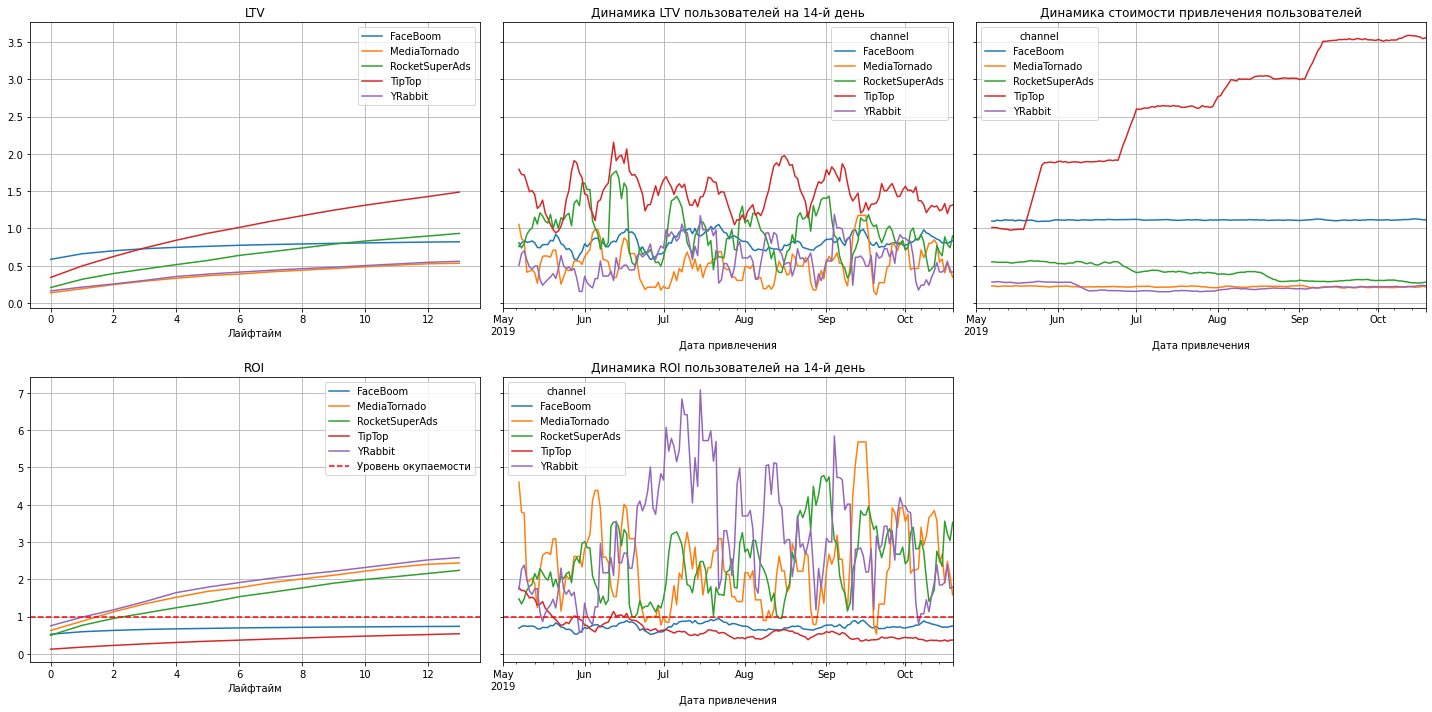

In [55]:
# анализируем окупаемость рекламы с разбивкой по каналам

# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw_USA, ltv_USA, ltv_history_USA, roi_USA, roi_history_USA = get_ltv(
    users_USA, orders, observation_date, horizon, dimensions=['channel']
)

plot_ltv_roi(ltv_USA, ltv_history_USA, roi_USA, roi_history_USA, horizon, window=7)

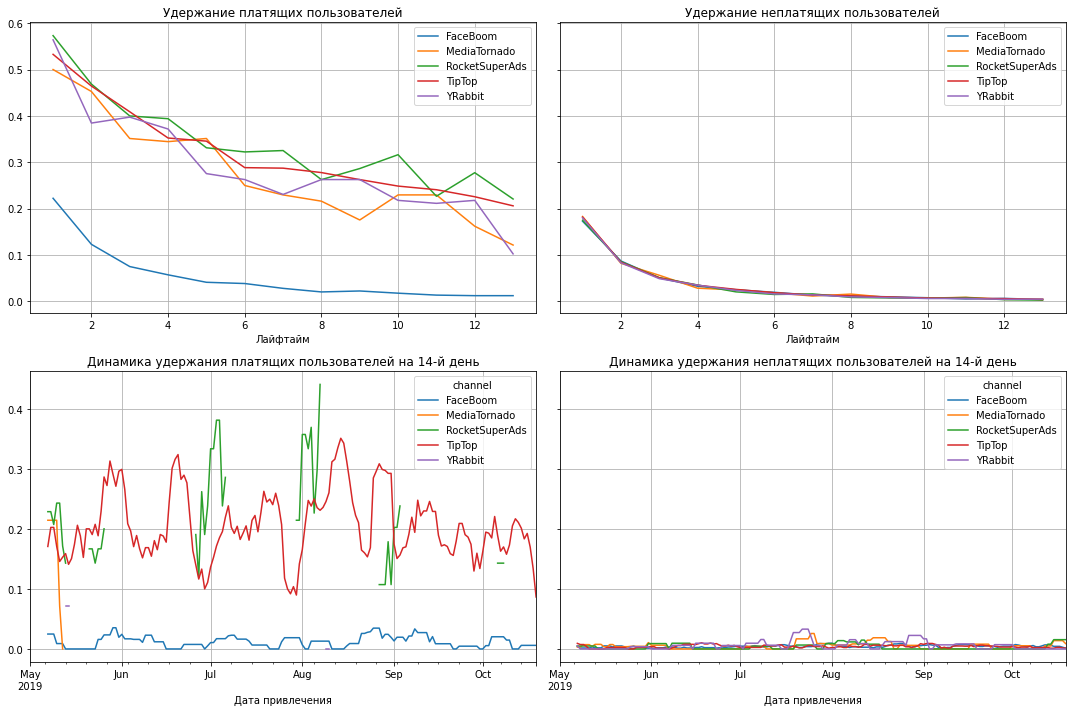

In [56]:
# анализируем графики удержания с разбивкой по каналам

retention_raw_USA, retention_USA, retention_history_USA = get_retention(
    users_USA, visits, observation_date, horizon, dimensions=['channel']
)

plot_retention(retention_USA, retention_history_USA, horizon, window=7)

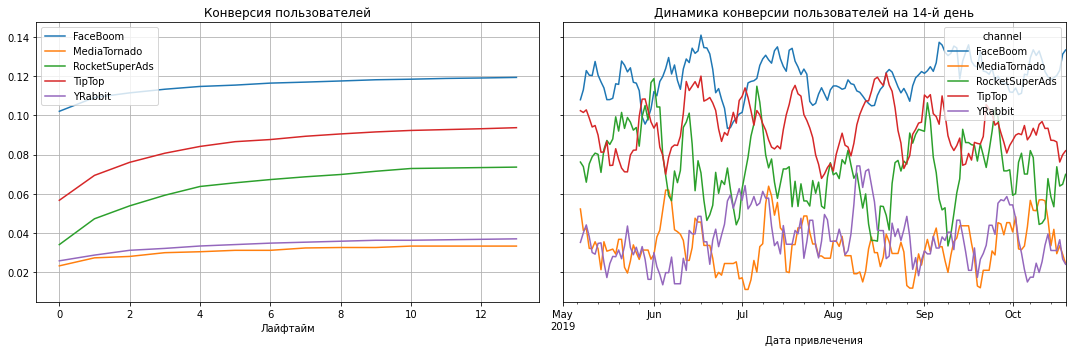

In [57]:
# анализируем графики конверсии с разбивкой по каналам

conversion_raw_USA, conversion_USA, conversion_history_USA = get_conversion(
    users_USA, orders, observation_date, horizon, dimensions=['channel']
)

plot_conversion(conversion_USA, conversion_history_USA, horizon, window=7)

Наиболее популярные каналы для привлечения пользователей TipTop и FaceBoom. Но если у FaceBoom расходы высокие, но они равномерны на протяжении всего периода анализа, то расходы на TipTop резко растут от месяца к месяцу. При этом реклама на обоих этих каналах не окупается, в отличие от других каналов. У FaceBoom еще и самое низкое удержание платящих пользователей, но самая высокая конверсия.

### Анализ рекламы в Европе

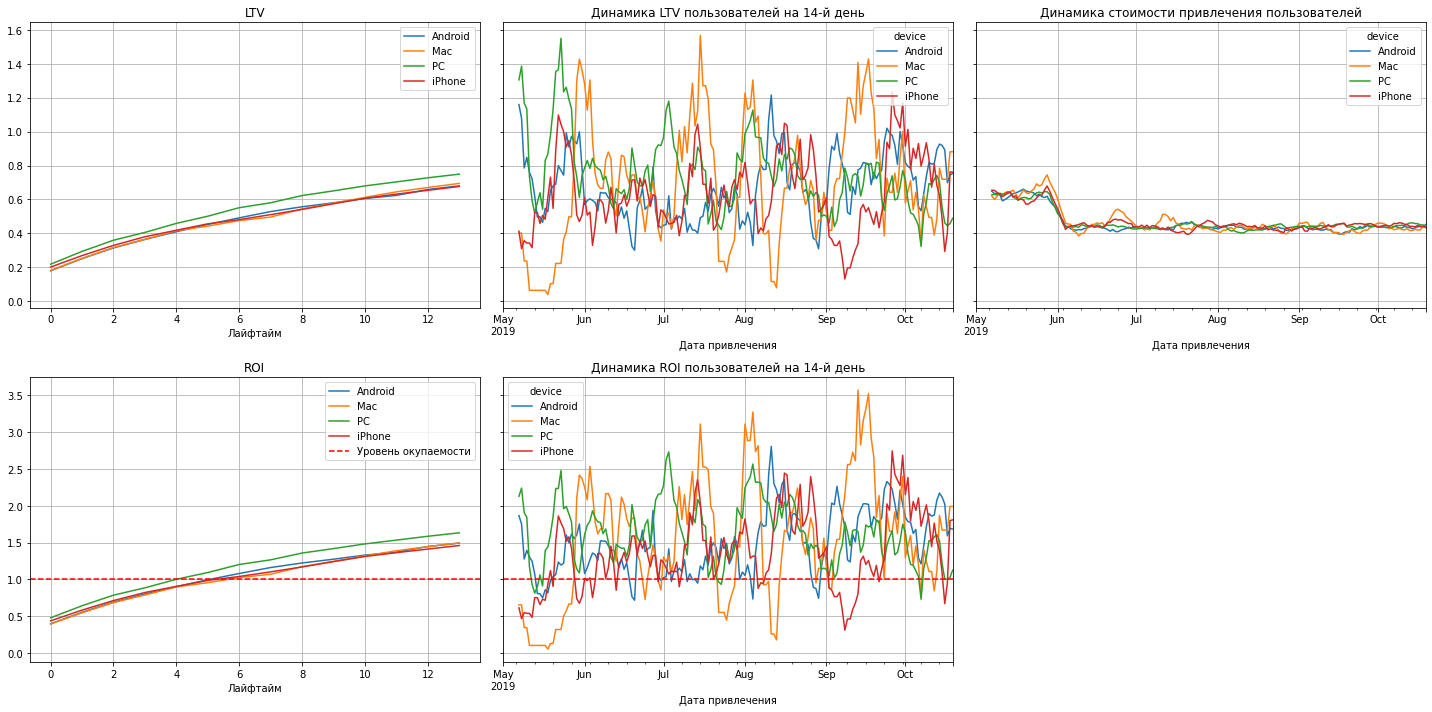

In [58]:
# анализируем окупаемость рекламы с разбивкой по устройствам

users_EU = users.query('region != "United States" and channel != "organic"')

# строим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw_EU, ltv_EU, ltv_history_EU, roi_EU, roi_history_EU = get_ltv(
    users_EU, orders, observation_date, horizon, dimensions=['device']
)

plot_ltv_roi(ltv_EU, ltv_history_EU, roi_EU, roi_history_EU, horizon, window=7)

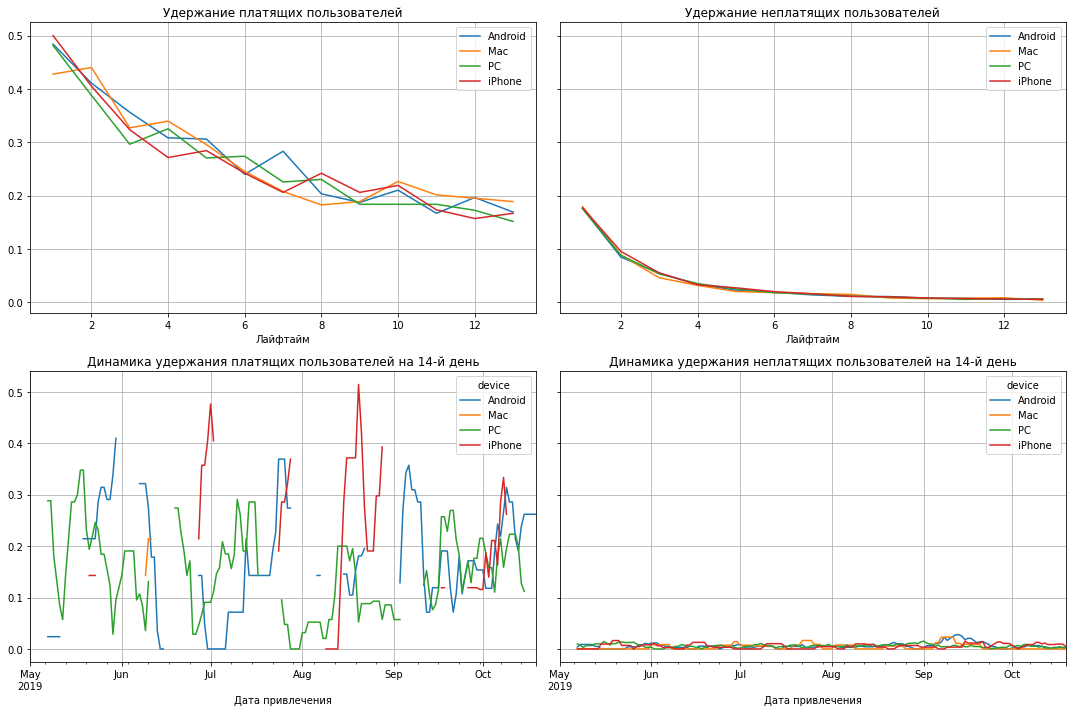

In [59]:
# анализируем графики удержания с разбивкой по устройствам

retention_raw_EU, retention_EU, retention_history_EU = get_retention(
    users_EU, visits, observation_date, horizon, dimensions=['device']
)

plot_retention(retention_EU, retention_history_EU, horizon, window=7)

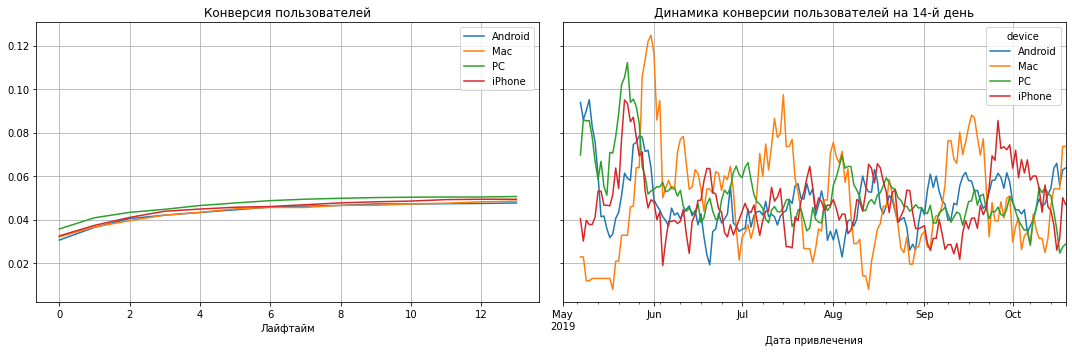

In [60]:
# анализируем графики конверсии с разбивкой по устройствам

conversion_raw_EU, conversion_EU, conversion_history_EU = get_conversion(
    users_EU, orders, observation_date, horizon, dimensions=['device']
)

plot_conversion(conversion_EU, conversion_history_EU, horizon, window=7)

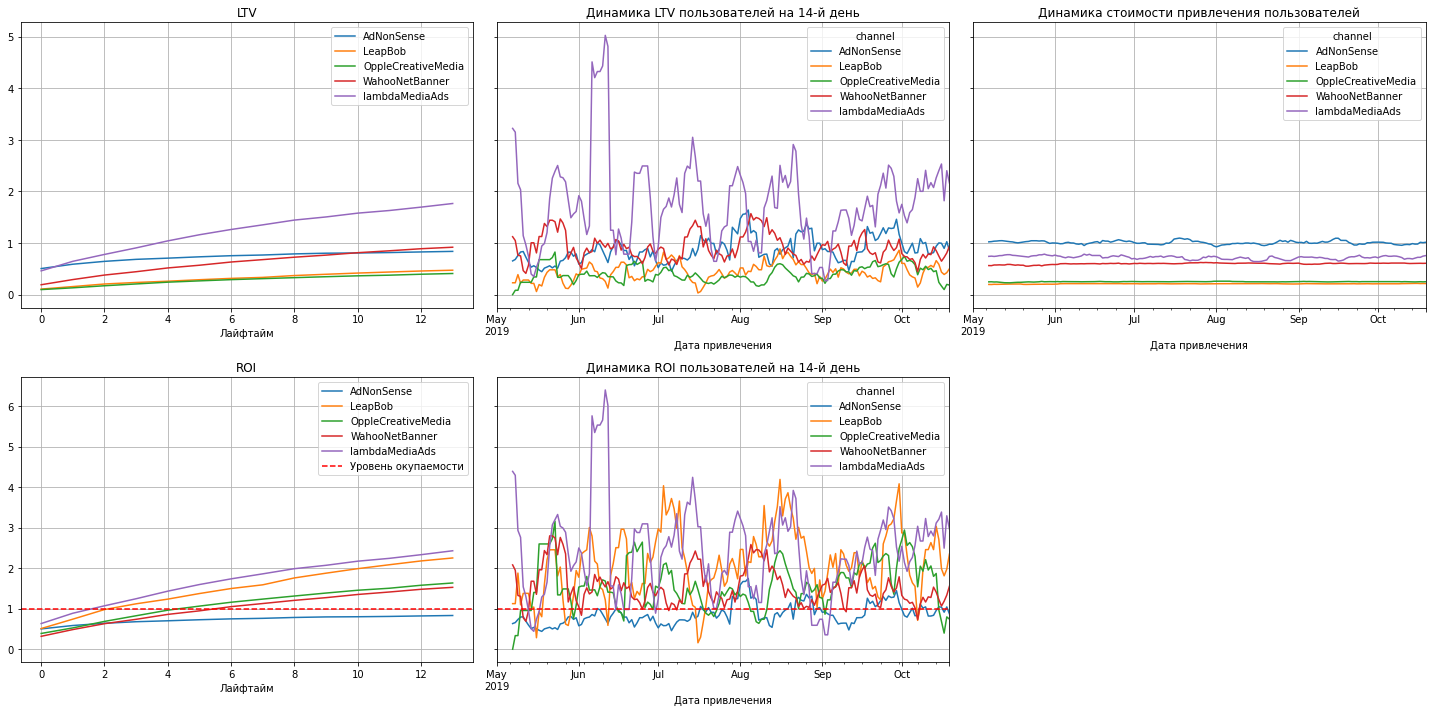

In [61]:
# анализируем окупаемость рекламы с разбивкой по каналам


ltv_raw_EU, ltv_EU, ltv_history_EU, roi_EU, roi_history_EU = get_ltv(
    users_EU, orders, observation_date, horizon, dimensions=['channel']
)

plot_ltv_roi(ltv_EU, ltv_history_EU, roi_EU, roi_history_EU, horizon, window=7)

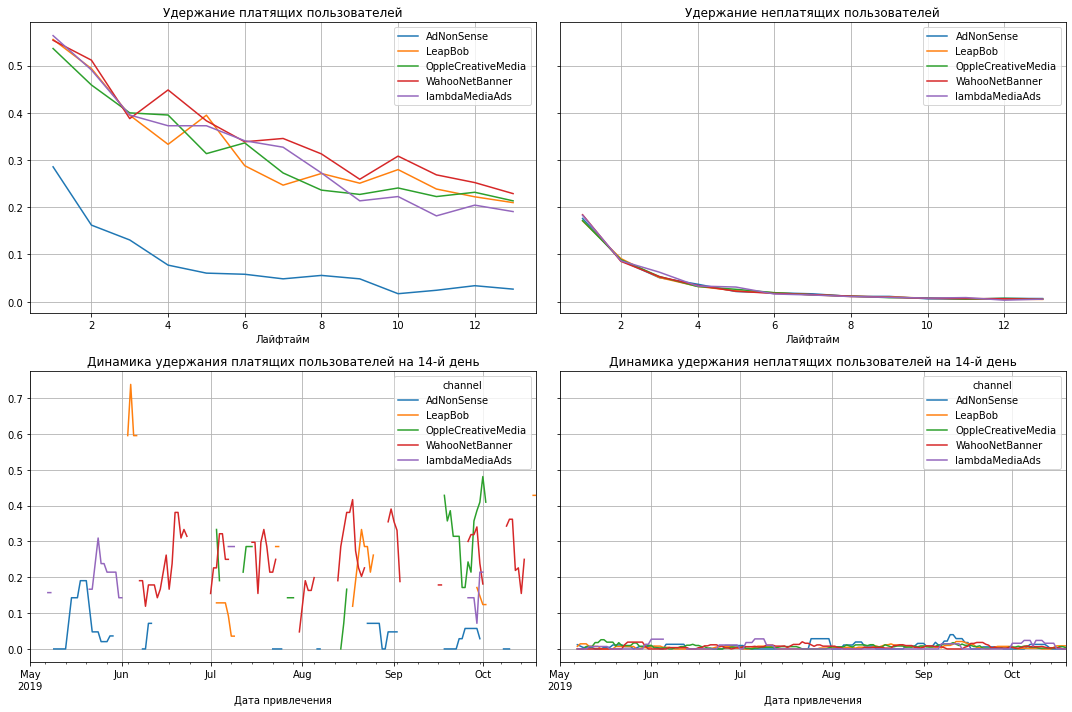

In [62]:
# анализируем графики удержания с разбивкой по каналам

retention_raw_EU, retention_EU, retention_history_EU = get_retention(
    users_EU, visits, observation_date, horizon, dimensions=['channel']
)

plot_retention(retention_EU, retention_history_EU, horizon, window=7)

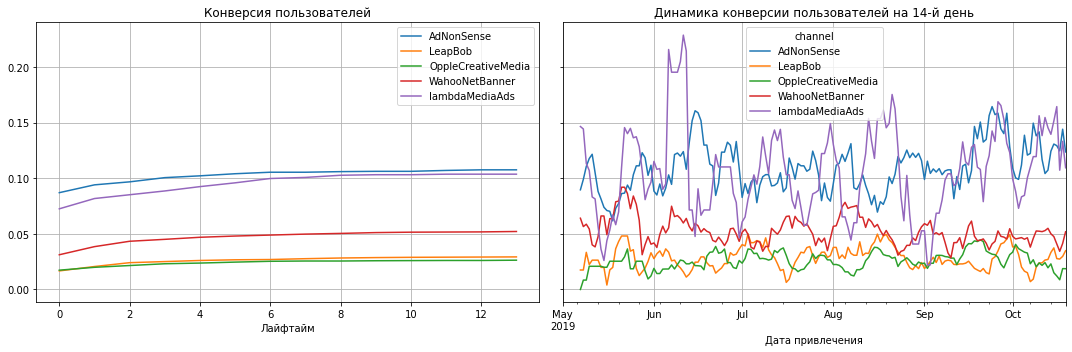

In [63]:
# анализируем графики конверсии с разбивкой по каналам

conversion_raw_EU, conversion_EU, conversion_history_EU = get_conversion(
    users_EU, orders, observation_date, horizon, dimensions=['channel']
)

plot_conversion(conversion_EU, conversion_history_EU, horizon, window=7)

В Европе окупаются все каналы, кроме AdNonSense, у которого наиболее высокие расходы на привлечение пользователей, но тут не продвигают продукты в таких популярных каналах, как TipTop и FaceBoom. Лучшая конверсия и окупаемость у канала lambdaMediaAds, они же вторые по расходам на рекламу.

### Вывод:

В целом, реклама в рассматриваемый период не окупилась, при том, что стоимость привлечения пользователей со временем росли.

Из всех устройств только пользователи PC пересекают уровень окупаемости на 11 день, остальные до этого уровня не доходят. При этом расходы на рекламу для пользователей PC наиболее низкие из всех, но у них наиболее высокое удержание платящих пользователей. Наиболее высокие расходы на привлечение пользователей iPhone и Mac, но у них же и наиболее низкая окупаемость, но наиболее высокая конверсия.

Из всех стран США оказались единственной страной, которая продемонстрировала убытки по ROI при растущих расходах на рекламу. При этом у них наиболее высокая конверсия и низшее удержание платящих пользователей. В этой стране очень высокие затраты на рекламы на каналах FaceBoom и TipTop, которые абсолютно не окупаются, в отличие от трех других каналов.

В Европе же окупаются 4 канала из 5, но нет продвижения в наиболее популярных TipTop и FaceBoom.

Самые высокие затраты на привлечение пользователей и, при этом, самая низкая окупаемость у канала TipTop.

## Общий вывод

### Цель проекта:
Разобраться в причинах убытков и помочь компании выйти в плюс.

### Входные данные:
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.


### Предобработка данных:
1. Изменены наименования столбцов:
    1. все столбцы - наименования приведены к нижнему регистру, заменены пробелы на нижнее подчеркивание.
2. Столбцы с датами приведены к формату datetime:
    1. 'session_start', 'session_end'в таблице visits;
    2. 'event_dt' в таблице orders;
    3. 'dt' в таблице costs.

В исследовании проанализированы данные по 150 тыс. пользователям приложения Procrastinate Pro+ из США, Великобритании, Франции и Германии. США лидируют по всем показателям:
* общее количество пользователей около 100 тыс., что в 6-7 раз больше, чем у других стран,
* количество платящих пользователей около 6.9 тыс., что в 10-11 раз больше, чем у других стран,
* процент платящих пользователей 6.9%.

Пользователи заходят в приложение с 4 типов устройств - iPhone, Android, Mac и PC. Наиболее популярным устройством является iPhone:
* общее количество пользователей около 54.5 тыс., что в 1.5 раз больше, чем у Android, который на 2м месте,
* количество платящих пользователей около 3.4 тыс., что в 1.6 раз больше, чем у Android,
* процент платящих пользователей 6.21%, но тут уступается первенство Mac, у которого процент платящих пользователей выше и составляет 6.36%.

Количество рекламных источников привлечения пользователей - 10. Наибольший траффик составляют пользователи из органического канала - 54.4 тыс. Далее следуют пользователи из FaceBoom и TipTop (29.1 и 19.4 тыс. соответсввенно), они же являются и лидерами по количеству платящих пользователей (3.6 и 1.9 тыс. соответственно), тогда как Organic только на третьем месте по количеству платящих пользователей (1.2 тыс.).  
Если посмотреть на таблицу с процентами платящих пользователей по каналам, то лидерах будут FaceBoom (12.2%), AdNonSense (11.34%), lambdaMediaAds (10.47%), TipTop только на 4м месте (9.6%), а на последнем месте Organic (2.06). Видно, что у каналов AdNonSense и lambdaMediaAds одни из наиболее высоких процентов платящих пользователей, но при этом у них самые низкие показатели общего количества клиентов.

Общая сумма расходов на рекламу составила 105.5 тыс условных денежных единиц (у.е.).

Наибольшая сумма затрат на рекламу пришлась на канал TipTop. На втором месте канал FaceBoom. Эти два канала являются основными каналами привлечения пользователей, т.к. на них приходится большая часть затрат, а также у них наибольшая средняя стоимость привлечения на пользователя (2.8 и 1.11 у.е. соответственно). Средняя стоимость привлечения одного пользователя в целом составила 1.13 у.е.

Наибольшие общие затраты на рекламные кампании пришлись на сентябрь, до этого времени затраты росли, начиная с мая, но рост затрат происходил за счет роста затрат в канале TipTop, которые росли каждый месяц. Затраты FaceBoom выросли в июне, после уже не поднимались, а затраты на остальные каналы на протяжении всего времени оставались одинаковыми.

В целом, реклама в рассматриваемый период не окупилась, при том, что стоимость привлечения пользователей со временем росли.

Из всех устройств только пользователи PC пересекают уровень окупаемости на 11 день, остальные до этого уровня не доходят. При этом расходы на рекламу для пользователей PC наиболее низкие из всех, но у них наиболее высокое удержание платящих пользователей. Наиболее высокие расходы на привлечение пользователей iPhone и Mac, но у них же и наиболее низкая окупаемость, но наиболее высокая конверсия.  
Из всех стран США оказались единственной страной, которая продемонстрировала убытки по ROI при растущих расходах на рекламу. При этом у них наиболее высокая конверсия и низшее удержание платящих пользователей.  В этой стране очень высокие затраты на рекламы на каналах FaceBoom и TipTop, которые абсолютно не окупаются, в отличие от трех других каналов. 
В Европе же окупаются 4 канала из 5, но нет продвижения в наиболее популярных TipTop и FaceBoom.  
Самые высокие затраты на привлечение пользователей и, при этом, самая низкая окупаемость у канала TipTop, .

Высокие расходы на привлечение пользователей являются именно тем фактором, который приводит к убыткам, которые терпит компания. Отделу маркетинга в первую очередь нужно сократить расходы на канал TipTop в США, т.к. именно там самая высокая стоимость привлечения клиентов, но при этом самая низкая окупаемость. Также по тем же причинам пересмотреть в сторону понижения рекламный бюджет для пользователей iPhone и Mac.  
Касательно отдельных рынков: в США рекомендуется обратить внимание на канал RocketSuperAds - это один из трех окупающихся каналов, среди которых у этого канала наиболее высокие показатели конверсии и удержания. А в Европе уменьшить рекламный бюджет канала AdNonSense и обратить внимание на пользователей TipTop И FaceBoom - если эти каналы достаточно популярны в Европе, то необходимо начать размещать рекламу там, но в разумных количествах, начиная с небольшого бюджета.